<a href="https://colab.research.google.com/github/aman-welzin/credzin/blob/main/scrapers/Web_Scraping_Firecrawl_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install firecrawl-py phi langchain langchain-community
!pip install ollama requests
!pip install beautifulsoup4 phidata --upgrade openai
!pip install duckduckgo-search newspaper4k lxml_html_clean ollama
!pip install gspread google-auth google-auth-oauthlib google-auth-httplib2

# import modules
from bs4 import BeautifulSoup
import requests

from pydantic import BaseModel, Field
from typing import Optional

from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from dotenv import load_dotenv
from langchain import PromptTemplate
from langchain.chains import LLMChain
from langchain.llms.ollama import Ollama
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
import csv

from phi.agent import Agent
from phi.model.openai import OpenAIChat
from phi.tools.duckduckgo import DuckDuckGo
from phi.tools.newspaper4k import Newspaper4k
from phi.model.ollama import Ollama

from google.colab import drive
import pprint

# Install and Import Libraries for google spreadsheet
from google.colab import auth
from google.auth import default
import gspread
import pandas as pd


# Mount google drive
drive.mount('/content/drive')

# Authenticate your Google account to grant Colab access to your Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Install Ollama and CUDA drivers
import os
!curl https://ollama.ai/install.sh | sh
!echo 'debconf debconf/frontend select Noninteractive' | sudo debconf-set-selections
!sudo apt-get update && sudo apt-get install -y cuda-drivers

# Set LD_LIBRARY_PATH so the system NVIDIA library
os.environ.update({'LD_LIBRARY_PATH': '/usr/lib64-nvidia'})

#Run Ollama server
!nohup ollama serve &
!ollama ps

!ollama pull deepseek-r1:14b  #[deepseek-r1:1.5b, deepseek-r1:7b, deepseek-r1:32b]

#pull llama3.1 model
!ollama pull llama3.1

#show list
!ollama list

# Open the Google Sheet
sh = gc.open('credit_card_details')

# Access a Worksheet
worksheet = sh.worksheet('card_issuers') #access sheet named card_issuers

# Get Data
# data = worksheet.get_all_values()

# Convert to Pandas DataFrame
df = pd.DataFrame(worksheet.get_all_records())

# Print DataFrame
# df

# Store Credit card url and bank name in lists
credit_card_url_list = df['credit_card_url'].to_list()
bank_name_list = df['bank_name'].to_list()
print("credit_card_url_list : ", credit_card_url_list)
print("bank_name_list : ", bank_name_list)

# Firecrawl API key and Firecrawl API url
Firecrawl_api_key = "fc-10264717717142beb2e09dd048cdcdc0"
Firecrawl_api_url = "https://api.firecrawl.dev/v1/scrape"

headers = {"Authorization": f"Bearer {Firecrawl_api_key}", "Content-Type": "application/json"}

# Create a directory to store the CSV files
output_directory = "/content/drive/MyDrive"
os.makedirs(output_directory, exist_ok=True)

# Iterate through URLs and bank names
for bank_name, target_url in zip(bank_name_list, credit_card_url_list):
    payload = {
        "url": target_url,
        "formats": ["json"],
        "jsonOptions": {
            "prompt": "Extract all name and image url of cards available on the page"
            "output should be in simple format and also without any sign value"
            "Provide the extracted information in a JSON format with the following keys: name, image_url"
        }
    }

    response = requests.post(Firecrawl_api_url, json=payload, headers=headers)

    if response.status_code == 200:
        data = response.json()
        print(json.dumps(data, indent=4))
        if "data" in data and "json" in data["data"] and "cards" in data["data"]["json"]:
            credit_cards_raw = data["data"]["json"]["cards"]
            credit_cards = [{"card_name": card["name"].strip(), "image_url": card["image_url"].strip()} for card in credit_cards_raw]
        else:
            print("Error: 'credit_cards' data not found in the Firecrawl response.")
            credit_cards = []
    else:
        print(f"Error: {response.status_code}, {response.text}")
        credit_cards = []

    print(len(credit_cards))

    filename_initial=f"{bank_name}_credit_cards_initial.csv"

    if credit_cards:
        # with open(filename_initial, 'w', newline='', encoding='utf-8') as csvfile:
        with open(filename_initial, 'w', newline='') as csvfile:
            fieldnames = ['card_name', 'image_url']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(credit_cards)
        print(f"CSV file '{filename_initial}' created successfully.")
    else:
        print(f"No credit card data received from Firecrawl. '{filename_initial}' not created.")
        exit()

    #AI Agent
    agent = Agent(
        name = "Credit Card Analyzer",
        model=Ollama(model_name="deepseek-r1:14b"),
        tools=[DuckDuckGo(), Newspaper4k()],
        description="You are an Indian credit card analysis expert. You analyze credit cards and extract detailed information.",
        instructions=[
            "You are an expert in analyzing Indian credit cards.",
            "For the credit card named in the input, perform the following steps:",
            "1. Search the web for detailed information about the specific credit card.",
            "2. Extract relevant details such as joining fee, annual fee, benefits, features, and links.",
            "3. Provide the extracted information in a JSON format with the following keys:",
            "bank_name,card_name,joining_fee,annual_fee,annual_fee_waiver,add_on_card_fee,interest_rate_pa,card_type,card_category,card_usp,movie_offer,fuel_offer,culinary_treats,airport_lounge_access,reward_points,returns_rate,rewards,features,know_more_link,apply_now_link",
            "If specific information is not found, leave the corresponding field blank.",
            "Do not include any introductory or concluding remarks in your response. Output only the JSON.",
            "Every output value should be simple and without any sign value",
        ],
        markdown=True,
        show_tool_calls=True,
        add_datetime_to_instructions=True,
        # debug_mode=True,
    )

    # Define the final file path in Google Drive
    final_file_path = f"/content/drive/My Drive/{bank_name}_Bank_credit_cards_details.csv"
    all_card_details = []

    # Read the initial CSV file
    initial_df = pd.read_csv(filename_initial)

    for index, row in initial_df.iterrows():
        card_name = row['card_name']
        image_url = row['image_url']
        print(f"\n--- Analyzing {card_name} ---\n")
        agent_response = agent.run(card_name, stream=False)
        print("Agent Response Content:")
        pprint.pprint(agent_response.content)

        json_match = re.search(r"\{[\s\S]*\}", agent_response.content)
        if json_match:
            try:
                card_data = json.loads(json_match.group(0))
                card_data['card_name'] = card_name
                card_data['card_image'] = image_url
                card_data['bank_name'] = f"{bank_name}" # Assuming all cards are from IndusInd
                all_card_details.append(card_data)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON for {card_name}: {e}")
                print(f"Problematic JSON string: {json_match.group(0)}")
        else:
            print(f"No JSON data found for {card_name}")

        # Convert the list of dictionaries to a Pandas DataFrame
    if all_card_details:
        final_df = pd.DataFrame(all_card_details)
        # Reorder columns to match the desired output
        column_order = ["bank_name", "card_name", "card_image", "joining_fee", "annual_fee", "annual_fee_waiver",
                        "add_on_card_fee", "interest_rate_pa", "card_type", "card_category", "card_usp",
                        "movie_offer", "fuel_offer", "culinary_treats", "airport_lounge_access", "reward_points",
                        "returns_rate", "rewards", "features", "know_more_link", "apply_now_link","image_url"]
        final_df = final_df.reindex(columns=column_order)

        # Interchange the data in 'image_url' and 'card_image' columns
        image_url_data = final_df['image_url'].copy()
        final_df['image_url'] = final_df['card_image']
        final_df['card_image'] = None

        # final_df.to_csv(final_file_path, index=False, encoding='utf-8')
        final_df.to_csv(final_file_path, index=False)

        print(f"\nDetailed credit card information saved to {final_file_path}")
    else:
        print("\nNo detailed credit card information extracted.")

Streaming output truncated to the last 5000 lines.
pulling 6e9f90f02bb3...  82% ▕▏ 7.4 GB/9.0 GB  237 MB/s      6spulling manifest 
pulling 6e9f90f02bb3...  82% ▕▏ 7.4 GB/9.0 GB  237 MB/s      6spulling manifest 
pulling 6e9f90f02bb3...  82% ▕▏ 7.4 GB/9.0 GB  237 MB/s      6spulling manifest 
pulling 6e9f90f02bb3...  82% ▕▏ 7.4 GB/9.0 GB  237 MB/s      6spulling manifest 
pulling 6e9f90f02bb3...  82% ▕▏ 7.4 GB/9.0 GB  237 MB/s      6spulling manifest 
pulling 6e9f90f02bb3...  82% ▕▏ 7.4 GB/9.0 GB  237 MB/s      6spulling manifest 
pulling 6e9f90f02bb3...  82% ▕▏ 7.4 GB/9.0 GB  237 MB/s      6spulling manifest 
pulling 6e9f90f02bb3...  82% ▕▏ 7.4 GB/9.0 GB  237 MB/s      6spulling manifest 
pulling 6e9f90f02bb3...  82% ▕▏ 7.4 GB/9.0 GB  237 MB/s      6spulling manifest 
pulling 6e9f90f02bb3...  82% ▕▏ 7.4 GB/9.0 GB  237 MB/s      6spulling manifest 
pulling 6e9f90f02bb3...  82% ▕▏ 7.4 GB/9.0 GB  224 MB/s      7spulling manifest 
pulling 6e9f90f02bb3...  82% ▕▏ 7.4 GB/9.0 GB  224 MB/s   

KeyboardInterrupt: 

In [ ]:
# Code to read google worksheets

!pip install gspread google-auth google-auth-oauthlib google-auth-httplib2

# Install and Import Libraries for google spreadsheet
from google.colab import auth
from google.auth import default
import gspread
import pandas as pd

# Authenticate your Google account to grant Colab access to your Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the Google Sheet
sh = gc.open('credit_card_details')

# Access a Worksheet
worksheet = sh.worksheet('card_issuers') #access sheet named card_issuers

# Get Data
# data = worksheet.get_all_values()

# Convert to Pandas DataFrame
df = pd.DataFrame(worksheet.get_all_records())

# Print DataFrame
df

,bank_name,website,credit_card_url,debit_card_url,cc_count,dc_count,more_sites_scrape
0,Axis,https://www.axisbank.com/,https://www.axisbank.com/retail/cards/credit-card,https://www.axisbank.com/retail/cards/debit-cards,40,,https://cardinsider.com/
1,SBI,https://www.onlinesbi.sbi/,https://www.sbicard.com/en/personal/credit-car...,https://sbi.co.in/web/personal-banking/cards/d...,150,,https://cardinsider.com/
2,HDFC,https://www.hdfcbank.com/,https://www.hdfcbank.com/personal/pay/cards/cr...,https://www.hdfcbank.com/personal/pay/cards/de...,49,,https://cardinsider.com/
3,ICICI,https://www.icicibank.com/,https://www.icicibank.com/personal-banking/car...,https://www.icicibank.com/personal-banking/car...,,,https://cardinsider.com/\nhttps://www.paisabaz...
4,Amex,https://www.americanexpress.com/en-in/,https://www.americanexpress.com/in/credit-card...,N/A,7,N/A,https://cardinsider.com/
5,Yes,https://www.yesbank.in/,https://www.yesbank.in/personal-banking/yes-in...,https://www.yesbank.in/personal-banking/yes-in...,20,,https://cardinsider.com/
6,IDFC,https://www.idfcfirstbank.com/,https://www.idfcfirstbank.com/credit-card,https://www.idfcfirstbank.com/personal-banking...,13,,
7,AU,https://www.aubank.in/,https://www.aubank.in/personal-banking/credit-...,https://www.aubank.in/personal-banking/debit-c...,7,,
8,IDBI,https://www.idbibank.in/index.aspx,https://www.idbibank.in/credit-card.aspx,https://www.idbibank.in/debit-card.aspx,5,18,
9,IndusInd,https://www.indusind.com/in/en/personal.html,https://www.indusind.com/in/en/personal/cards/...,https://www.indusind.com/in/en/personal/cards/...,34,33,


# Pandas EDA

worksheet:  <Worksheet 'card_issuers' id:687992344>
worksheet:  <Worksheet 'Axis' id:0>
worksheet:  <Worksheet 'SBI' id:1025604944>
worksheet:  <Worksheet 'Kotak' id:15305923>
worksheet:  <Worksheet 'HDFC' id:1024940451>
worksheet:  <Worksheet 'ICICI' id:440168061>
worksheet:  <Worksheet 'Amex' id:1240129374>
worksheet:  <Worksheet 'Yes' id:1219059337>
worksheet:  <Worksheet 'AU' id:794105848>
worksheet:  <Worksheet 'IDFC' id:1274780381>
worksheet:  <Worksheet 'IDBI' id:1101391873>
worksheet:  <Worksheet 'Induslnd' id:1658135018>
worksheet:  <Worksheet 'HSBC' id:2046880409>
worksheet:  <Worksheet 'Standard_Chartered' id:2032518551>
worksheet:  <Worksheet 'BOBCARD' id:1049108936>
worksheet:  <Worksheet 'Federal' id:1013468317>


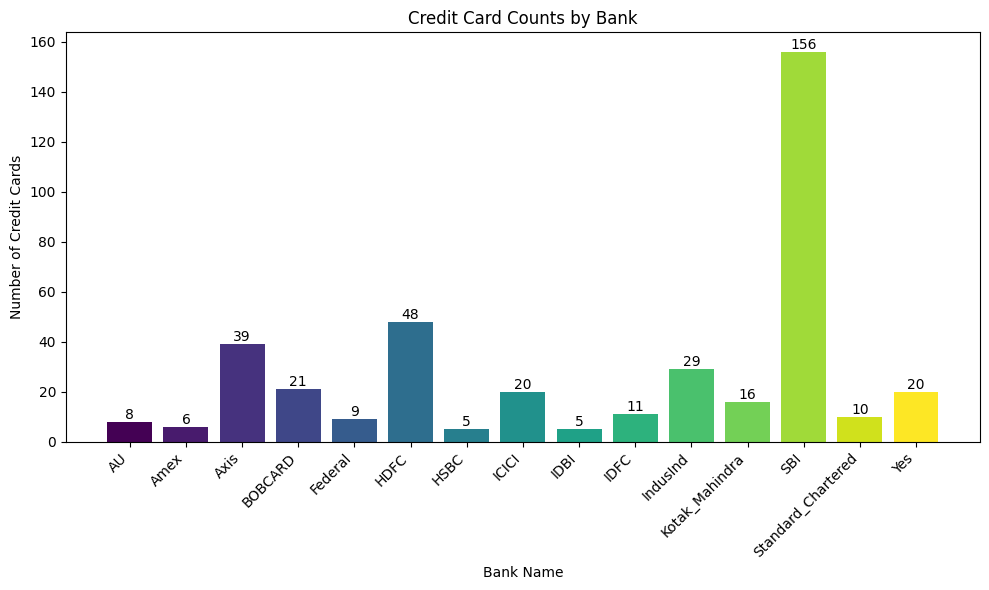

In [ ]:
# Code to read google worksheets
!pip install gspread google-auth google-auth-oauthlib google-auth-httplib2

# Install and Import Libraries for google spreadsheet
from google.colab import auth
from google.auth import default
import gspread
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# Authenticate your Google account to grant Colab access to your Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
sh = gc.open('credit_card_details')

# Get all worksheets
worksheets = sh.worksheets()
all_dfs = {}

# Iterate through each worksheet
for worksheet in worksheets:
  print('worksheet: ', worksheet)
  if worksheet.title != 'card_issuers':
    title = worksheet.title
    df = pd.DataFrame(worksheet.get_all_records())
    all_dfs[title] = df

# Concatenate all dataframes in the dictionary
merged_df = pd.concat(all_dfs.values(), ignore_index=True)
merged_df

# Group data by bank name and count credit cards
bank_counts = merged_df.groupby('bank_name')['card_name'].count().reset_index()

# Create the bar graph
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
colors = cm.viridis(np.linspace(0, 1, len(bank_counts)))  # Get colors from viridis colormap
bars = plt.bar(bank_counts['bank_name'], bank_counts['card_name'], color=colors)
plt.xlabel("Bank Name")
plt.ylabel("Number of Credit Cards")
plt.title("Credit Card Counts by Bank")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Add count labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')
plt.show()

In [ ]:
merged_df.shape
merge

(403, 25)